## 04 Bigram WordCloud using gensim

This is a general function that calculates tfidf model
and I can plot the wordcloud

Generally, products have all kind of reviews, some bad, some good. Only part of the bad reviews are sticky reviews, with a sequence of low-score reviews after them. I would like to compare the sticky reviews to the general bad reviews. The Data Frame longRev3 contains only bad reviews - or "dip" reviews as they appear in the code. Here, bad reveiws are defiend by reviews with a score at least 1.5 stars lower than the product's average score.
Sticky reviews, defined in a previous notebook, are labeled "True" in the column "TFsticky".

In [1]:
import numpy as np
import pandas as pd
import pickle
import statistics

'''upload longRev2 again, corrected definition of sticky'''
file0 = open("../../from_TDI190606/capstone_TDI190606/ElongRev2_with_TFsticky.pkl","rb")
longRev2 = pickle.load(file0)
file0.close()

In [2]:
#longRev3: only dip reviews
longRev3 = longRev2[longRev2.TFdip==True]

In [5]:
#convert "True" to 1,0
longRev3.loc[:,'TFsticky'] = longRev3.loc[:,'TFsticky'].astype(int)

In [7]:
import re
from pprint import pprint
from nltk.corpus import stopwords

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

from gensim.models import TfidfModel
from wordcloud import WordCloud
import matplotlib.pyplot as plt

stop_words = stopwords.words('english')


In [22]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts,bigram_mod):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts,trigram_mod):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, nlp, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [23]:
def wordCloud_bytfidf(data,wctitle):
    ''' 8. break down each sentence into a list of words through tokenization, 
    while clearing up all the messy text in the process.
    Gensim’s simple_preprocess is great for this.
    '''
    #data_words is a list of lists of words
    data_words = list(sent_to_words(data))

    '''9. Phrases model '''
    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=2, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    # See trigram example
    #print(trigram_mod[bigram_mod[data_words[0][0:10]]])

    '''10. Remove Stopwords, Make Bigrams and Lemmatize'''
    # Define functions for stopwords, bigrams, trigrams and lemmatization
    '''calling the functions above'''
    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)

    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops,bigram_mod)

    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
    # python3 -m spacy download en
    #nlp = spacy.load('en', disable=['parser', 'ner'])
    nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, nlp, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    #print(data_lemmatized[:1][0][:10])


    '''11. Create the Dictionary and Corpus needed for wordcloud'''
    # Fit Dictionary
    id2word = corpora.Dictionary(data_lemmatized)

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in data_lemmatized]
    #Convert document (a list of words) into the 
    #bag-of-words format = list of (token_id, token_count) 
    #2-tuples.

    mytfidfmodel = TfidfModel(corpus)
    vector = mytfidfmodel[corpus[0]]
    vectors = mytfidfmodel[corpus]

    # Get TF-IDF weights (a list of tuples (#, frequency))
    weightslist = []
    for doc in vectors:
        weightsnum = mytfidfmodel[doc]
        weightsword = [(id2word[pair[0]], pair[1]) for pair in weightsnum]
        weightslist.extend(weightsword)
    weights = dict(weightslist)

    wc = WordCloud(
        background_color="white",
        max_words=2000,
        width=1024,
        height=720,
        stopwords=stopwords.words('english')
    )

    # Generate the cloud
    wc.generate_from_frequencies(weights)

    # Save the cloud to a file
    #wc.to_file("word_cloud.png") 

    # Display the generated image:
    plt.imshow(wc, interpolation='bilinear')
    plt.title(wctitle)
    plt.axis("off")
    plt.show()

In [24]:
# sticky reviews
datasticky = longRev3[longRev3.TFsticky==1].reviewText.values.tolist()

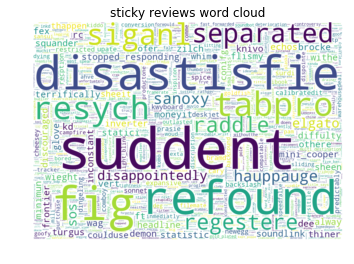

In [25]:
wctitle = 'sticky reviews word cloud'
wordCloud_bytfidf(datasticky, wctitle)

In [26]:
#non sticky reviews
datanonsticky = longRev3[longRev3.TFsticky==0].reviewText.values.tolist()

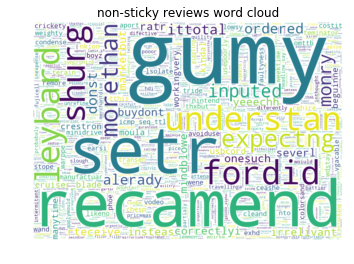

In [27]:
wctitle = 'non-sticky reviews word cloud'
wordCloud_bytfidf(datanonsticky, wctitle)